### EDA and Linear Regression

In [223]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [9]:
director='hitchcock'
dir_str = director + '/'

films_filename = 'films_to_analyze_' + director
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [10]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
prevalent_actors_filename  = 'prevalent_actors_' + director
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [12]:
prevalent_actor_columns

Index(['Leo G. Carroll', 'John Longden', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop', 'Cary Grant',
       'Edward Chapman', 'Basil Radford', 'George Curzon', 'Leslie Banks',
       'Grace Kelly', 'Ian Hunter', 'Patricia Hitchcock', 'Isabel Jeans',
       'Ingrid Bergman', 'Percy Marmont'],
      dtype='object')

In [13]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [14]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [15]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Leo G. Carroll',
 'John Longden',
 'Edmund Gwenn',
 'Gordon Harker',
 'James Stewart',
 'Hannah Jones',
 'Donald Calthrop',
 'Cary Grant',
 'Edward Chapman',
 'Basil Radford',
 'George Curzon',
 'Leslie Banks',
 'Grace Kelly',
 'Ian Hunter',
 'Patricia Hitchcock',
 'Isabel Jeans',
 'Ingrid Bergman',
 'Percy Marmont']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [16]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [18]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Leo G. Carroll,John Longden,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
2,Family Plot,1976.0,120.0,Leonard J. South,0.0,0.0,6.8,20794.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,116.0,Gilbert Taylor,0.0,0.0,7.4,41424.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,143.0,Jack Hildyard,0.0,0.0,6.3,16714.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,128.0,John F. Warren,0.0,0.0,6.7,24727.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,130.0,Robert Burks,0.0,0.0,7.2,45220.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [20]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [21]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Leo G. Carroll', 'John Longden',
       'Edmund Gwenn', 'Gordon Harker', 'James Stewart', 'Hannah Jones',
       'Donald Calthrop', 'Cary Grant', 'Edward Chapman', 'Basil Radford',
       'George Curzon', 'Leslie Banks', 'Grace Kelly', 'Ian Hunter',
       'Patricia Hitchcock', 'Isabel Jeans', 'Ingrid Bergman',
       'Percy Marmont'],
      dtype='object')

In [22]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [23]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Leo G. Carroll',
 'John Longden',
 'Edmund Gwenn',
 'Gordon Harker',
 'James Stewart',
 'Hannah Jones',
 'Donald Calthrop',
 'Cary Grant',
 'Edward Chapman',
 'Basil Radford',
 'George Curzon',
 'Leslie Banks',
 'Grace Kelly',
 'Ian Hunter',
 'Patricia Hitchcock',
 'Isabel Jeans',
 'Ingrid Bergman',
 'Percy Marmont']

In [257]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [258]:
y.isnull().values.any()

False

### Train-val vs. test split

In [259]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [260]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Leo G. Carroll,John Longden,Edmund Gwenn,Gordon Harker,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
2,1976.0,120.0,OTHER,0.0,0.0,20794.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1963.0,119.0,Robert Burks,0.0,0.0,171549.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,1939.0,98.0,Bernard Knowles,0.0,0.0,9121.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
51,1931.0,83.0,Jack E. Cox,0.0,0.0,3973.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16,1956.0,105.0,Robert Burks,0.0,0.0,25655.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,1928.0,129.0,Jack E. Cox,0.0,0.0,2496.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,1940.0,120.0,OTHER,0.0,0.0,18452.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,1930.0,92.0,Jack E. Cox,0.0,0.0,5782.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1941.0,99.0,Harry Stradling Sr.,0.0,0.0,32739.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65,1927.0,74.0,Claude L. McDonnell,0.0,0.0,2201.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [261]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [262]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [263]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Bernard Knowles',
       'cinematographer_Claude L. McDonnell',
       'cinematographer_Gaetano di Ventimiglia',
       'cinematographer_George Barnes',
       'cinematographer_Glen MacWilliams',
       'cinematographer_Harry Stradling Sr.',
       'cinematographer_Jack E. Cox', 'cinematographer_John F. Warren',
       'cinematographer_John L. Russell',
       'cinematographer_Joseph A. Valentine', 'cinematographer_OTHER',
       'cinematographer_Robert Burks'], dtype=object)

In [264]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,cinematographer_John F. Warren,cinematographer_John L. Russell,cinematographer_Joseph A. Valentine,cinematographer_OTHER,cinematographer_Robert Burks
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Repeating transformations on testing set

In [265]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [266]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
37,1942.0,109.0,23406.0
5,1966.0,128.0,24727.0
60,1929.0,110.0,2603.0
20,1955.0,106.0,65121.0
11,1959.0,60.0,127.0


#### Generate log and polynomials

In [135]:
#X_train_val_cont_poly.head()

In [267]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-267-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-267-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-267-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [270]:
X_test_cont.shape[0]

12

#### Concatenate columns

In [271]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [272]:
X_test_cat_df.isnull().values.any()

False

In [273]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [274]:
X_test_cat_df.shape

(12, 20)

In [275]:
X_train_val_combo.isnull().values.any()

False

In [276]:
X_test_combo.isnull().values.any()

False

In [277]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
0,1976.0,120.0,20794.0,7.588830,9.942420,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1963.0,119.0,171549.0,7.582229,12.052624,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1939.0,98.0,9121.0,7.569928,9.118335,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1931.0,83.0,3973.0,7.565793,8.287277,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1956.0,105.0,25655.0,7.578657,10.152494,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1928.0,129.0,2496.0,7.564238,7.822445,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1940.0,120.0,18452.0,7.570443,9.822928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1930.0,92.0,5782.0,7.565275,8.662505,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1941.0,99.0,32739.0,7.570959,10.396322,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1927.0,74.0,2201.0,7.563720,7.696667,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [278]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Bernard Knowles',
       'cinematographer_Claude L. McDonnell',
       'cinematographer_Gaetano di Ventimiglia',
       'cinematographer_George Barnes', 'cinematographer_Glen MacWilliams',
       'cinematographer_Harry Stradling Sr.', 'cinematographer_Jack E. Cox',
       'cinematographer_John F. Warren', 'cinematographer_John L. Russell',
       'cinematographer_Joseph A. Valentine', 'cinematographer_OTHER',
       'cinematographer_Robert Burks', 'documentary', 'tv_series',
       'Leo G. Carroll', 'John Longden', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop', 'Cary Grant',
       'Edward Chapman', 'Basil Radford', 'George Curzon', 'Leslie Banks',
       'Grace Kelly', 'Ian Hunter', 'Patricia Hitchcock', 'Isabel Jeans',
       'Ingrid Bergman', 'Percy Marmont'],
      dtype='object')

### Train vs. val split

In [279]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

### Manually tune regularization with both Lasso and Ridge

In [280]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

### Lasso CV

In [281]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [308]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [309]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [310]:
# This is the best alpha value it found 
lasso_model.alpha_

0.10595601792776159

In [311]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.0),
 ('rating_count', 0.0),
 ('log_year', 0.0),
 ('log_rating_count', 0.7200357963676149),
 ('cinematographer_Bernard Knowles', 0.0),
 ('cinematographer_Claude L. McDonnell', -0.0),
 ('cinematographer_Gaetano di Ventimiglia', 0.0),
 ('cinematographer_George Barnes', 0.0),
 ('cinematographer_Glen MacWilliams', 0.0),
 ('cinematographer_Harry Stradling Sr.', -0.0),
 ('cinematographer_Jack E. Cox', -0.007258314596966688),
 ('cinematographer_John F. Warren', 0.0),
 ('cinematographer_John L. Russell', -0.0),
 ('cinematographer_Joseph A. Valentine', 0.0),
 ('cinematographer_OTHER', 0.0),
 ('cinematographer_Robert Burks', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.3295050316080774),
 ('Leo G. Carroll', 0.0),
 ('John Longden', -0.0),
 ('Edmund Gwenn', -0.0),
 ('Gordon Harker', -0.0),
 ('James Stewart', 0.0),
 ('Hannah Jones', 0.0),
 ('Donald Calthrop', -0.0),
 ('Cary Grant', 0.0),
 ('Edward Chapman', -0.09157502808361034),
 ('Basil Radford', 0.0),
 ('George Cu

In [312]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [313]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.30696187527917146

In [314]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.7979136619102305

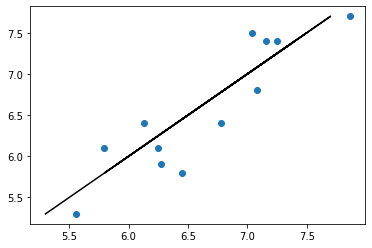

In [315]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

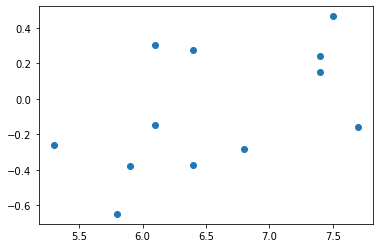

In [316]:
plt.scatter( y_test, y_test-test_set_pred)

In [ ]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)
coefficients_df.head()

In [317]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.30696187527917146,
 'coefficients': [('year', 0.0),
  ('duration', 0.0),
  ('rating_count', 0.0),
  ('log_year', 0.0),
  ('log_rating_count', 0.7200357963676149),
  ('cinematographer_Bernard Knowles', 0.0),
  ('cinematographer_Claude L. McDonnell', -0.0),
  ('cinematographer_Gaetano di Ventimiglia', 0.0),
  ('cinematographer_George Barnes', 0.0),
  ('cinematographer_Glen MacWilliams', 0.0),
  ('cinematographer_Harry Stradling Sr.', -0.0),
  ('cinematographer_Jack E. Cox', -0.007258314596966688),
  ('cinematographer_John F. Warren', 0.0),
  ('cinematographer_John L. Russell', -0.0),
  ('cinematographer_Joseph A. Valentine', 0.0),
  ('cinematographer_OTHER', 0.0),
  ('cinematographer_Robert Burks', 0.0),
  ('documentary', 0.0),
  ('tv_series', 0.3295050316080774),
  ('Leo G. Carroll', 0.0),
  ('John Longden', -0.0),
  ('Edmund Gwenn

In [318]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc' + director
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

### Rerun the model without using rating count

In [368]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
0,-0.227969,0.558328,-0.329114,-0.225084,0.261703,-0.301511,-0.145865,-0.208514,-0.208514,-0.208514,...,-0.208514,-0.208514,-0.208514,-0.208514,-0.258199,-0.208514,-0.258199,-0.145865,-0.258199,-0.208514
1,1.688969,1.393074,-0.318162,1.684286,0.289938,-0.301511,-0.145865,-0.208514,-0.208514,-0.208514,...,-0.208514,-0.208514,-0.208514,-0.208514,-0.258199,-0.208514,-0.258199,-0.145865,-0.258199,-0.208514
2,-1.266311,0.602262,-0.501584,-1.269202,-0.867793,-0.301511,-0.145865,-0.208514,-0.208514,-0.208514,...,-0.208514,-0.208514,-0.208514,-0.208514,-0.258199,-0.208514,-0.258199,-0.145865,-0.258199,-0.208514
3,0.810372,0.426526,0.016730,0.812068,0.787928,-0.301511,-0.145865,-0.208514,-0.208514,-0.208514,...,-0.208514,-0.208514,-0.208514,-0.208514,3.872983,-0.208514,-0.258199,-0.145865,-0.258199,-0.208514
4,1.129862,-1.594439,-0.522111,1.129805,-2.420996,-0.301511,-0.145865,-0.208514,-0.208514,-0.208514,...,-0.208514,-0.208514,-0.208514,-0.208514,-0.258199,-0.208514,-0.258199,-0.145865,-0.258199,-0.208514


In [369]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [370]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [371]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [372]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

100.0

In [373]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False).head(10)

In [374]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [375]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5096797312361602

In [376]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


0.3805667633301373

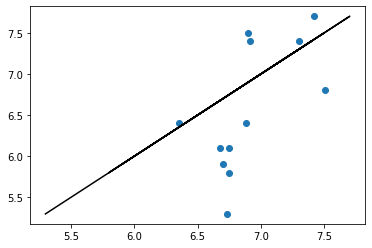

In [355]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

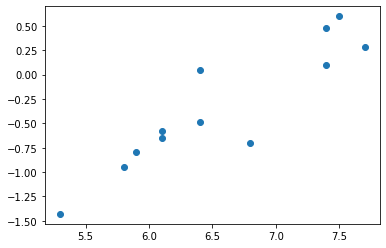

In [356]:
plt.scatter( y_test, y_test-test_set_pred)



In [ ]:
coefficients_df.head()

In [357]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5908899832138655,
 'coefficients':                          Feature  Coefficient
 2                       log_year     0.210968
 14  cinematographer_Robert Burks     0.054240
 21                 James Stewart     0.014401
 0                           year     0.000000
 26                 Basil Radford     0.000000
 20                 Gordon Harker    -0.000000
 22                  Hannah Jones     0.000000
 23               Donald Calthrop    -0.000000
 24                    Cary Grant     0.000000
 27                 George Curzon     0.000000}

,Feature,Coefficient
2,log_year,0.210968
14,cinematographer_Robert Burks,0.054240
21,James Stewart,0.014401
0,year,0.000000
26,Basil Radford,0.000000
20,Gordon Harker,-0.000000
22,Hannah Jones,0.000000
23,Donald Calthrop,-0.000000
24,Cary Grant,0.000000
27,George Curzon,0.000000


In [359]:
LCVM_no_rc_filename = 'Lasso_CV_model_w_rc' + director
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [336]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


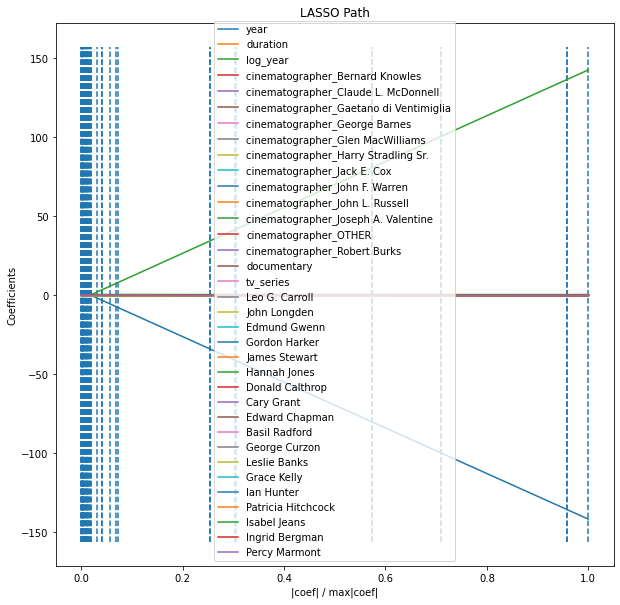

In [337]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [377]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [378]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False).head(10)

In [379]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [380]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5096797312361602

In [381]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


0.3805667633301373

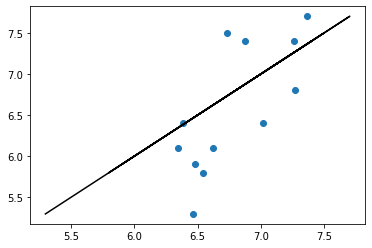

In [382]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

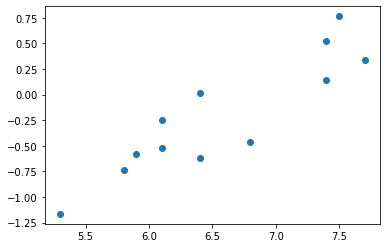

In [383]:
plt.scatter( y_test, y_test-test_set_pred)



In [384]:
coefficients_df.head()

,Feature,Coefficient
21,James Stewart,0.074625
2,log_year,0.068110
0,year,0.067865
14,cinematographer_Robert Burks,0.062818
31,Patricia Hitchcock,0.057897


In [385]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5096797312361602,
 'coefficients':                           Feature  Coefficient
 21                  James Stewart     0.074625
 2                        log_year     0.068110
 0                            year     0.067865
 14   cinematographer_Robert Burks     0.062818
 31             Patricia Hitchcock     0.057897
 29                    Grace Kelly     0.049003
 24                     Cary Grant     0.046755
 6   cinematographer_George Barnes     0.046696
 1                        duration     0.046106
 17                 Leo G. Carroll     0.044194}

In [386]:
RCVM_no_rc_filename = 'Ridge_CV_model_w_rc' + director
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

## Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [360]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

### Examine coefficients, residuals, pred vs. actual (and maybe QQ-plot)

In [71]:
#X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,cinematographer_John F. Warren,cinematographer_John L. Russell,cinematographer_Joseph A. Valentine,cinematographer_OTHER,cinematographer_Robert Burks
50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Continous Variable Preprocessing

#### Select continuous variables from training set

,year,duration,rating_count
50,1932.0,66.0,4429.0
3,1972.0,116.0,41424.0
33,1944.0,32.0,1448.0
30,1945.0,111.0,43415.0
53,1931.0,85.0,2874.0
37,1942.0,109.0,23406.0
47,1935.0,86.0,51765.0
62,1928.0,129.0,2496.0
64,1927.0,80.0,2524.0
44,1937.0,83.0,8634.0


####  scale the continuous variables in the train set

In [78]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
50,-0.985900,-1.297795,-0.484628
3,2.095037,0.796924,-0.189486
33,-0.061619,-2.722205,-0.508410
30,0.015405,0.587452,-0.173602
53,-1.062923,-0.501802,-0.497033


#### select and scale the continuous variables in the test set

In [79]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
59,1929.0,85.0,9637.0
66,1927.0,92.0,10391.0
61,1928.0,86.0,2025.0
45,1936.0,76.0,14941.0
39,1940.0,120.0,18452.0


In [80]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
59,-1.216970,-0.501802,-0.443079
66,-1.371017,-0.208541,-0.437063
61,-1.293993,-0.459907,-0.503806
45,-0.677806,-0.878851,-0.400764
39,-0.369712,0.964502,-0.372754


### Combine the continuous, categorical, and ohe cat features for our testing set


In [81]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [82]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
50,-0.985900,-1.297795,-0.484628,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.095037,0.796924,-0.189486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,-0.061619,-2.722205,-0.508410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.015405,0.587452,-0.173602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53,-1.062923,-0.501802,-0.497033,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,-0.215666,0.503664,-0.333231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,-0.754829,-0.459907,-0.106987,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,-1.293993,1.341552,-0.500049,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,-1.371017,-0.711274,-0.499825,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
44,-0.600783,-0.585591,-0.451081,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
X_train.shape

(45, 24)

### Combine the continuous and categorical features for our testing set


In [84]:
X_test_cat_df = X_test[cat_columns]

In [85]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [86]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Glen MacWilliams,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
0,-1.216970,-0.501802,-0.443079,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.371017,-0.208541,-0.437063,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.293993,-0.459907,-0.503806,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.677806,-0.878851,-0.400764,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.369712,0.964502,-0.372754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.631592,-0.082858,-0.367688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.862662,0.964502,-0.053559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.403130,0.964502,-0.354070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.831853,-0.920746,-0.384449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1.216970,0.545558,-0.499195,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [87]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [88]:
lr.coef_

array([-1.65049854e-02,  9.27033702e-02,  6.91975762e-01,  7.90776556e-01,
       -5.91019310e-01, -2.65116609e-01,  1.47723300e+00, -1.11735720e+00,
        3.80163933e-02, -2.15940217e-01,  3.46631720e-01, -2.09949589e+00,
        9.10218391e-01,  3.15219811e-01,  4.10833345e-01,  1.49880108e-15,
        1.83296799e+00, -4.42564561e-01, -6.06699472e-01,  8.49148905e-01,
       -3.56884841e-01, -1.82017688e-01,  7.20409233e-01, -7.01327427e-02,
        4.87951051e-01, -5.26722149e-01,  1.43655185e+00, -8.09687055e-01,
       -1.24499765e+00, -8.19848563e-02,  4.50429737e-01,  6.42827625e-01,
       -5.91019310e-01, -1.07261862e-01, -3.75219565e-01])

In [89]:
y_pred = lr.predict(X_test_combined)

y_pred

array([6.16772741, 6.10886526, 5.73039853, 7.11629524, 7.67506985,
       6.8114197 , 6.94005163, 6.79308422, 4.596002  , 6.18241299,
       7.61238841, 5.99912603, 7.75443638, 6.29331308, 5.34295303])

In [90]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 1.03
r2: -1.15


In [91]:
print(r2)

-1.1502689319265942


In [92]:
score = lr.score(X_test_combined, y_test) 
score

-1.1502689319265942

# Focus on building up from fewer features
for instance the continous ones

### Train Test Split

In [93]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Leo G. Carroll', 'John Longden',
       'Edmund Gwenn', 'Gordon Harker', 'James Stewart', 'Hannah Jones',
       'Donald Calthrop', 'Cary Grant', 'Edward Chapman', 'Basil Radford',
       'George Curzon', 'Leslie Banks', 'Grace Kelly', 'Ian Hunter',
       'Patricia Hitchcock', 'Isabel Jeans', 'Ingrid Bergman',
       'Percy Marmont'],
      dtype='object')

In [94]:
selected_cols = ['year', 'duration', 'rating_count']

In [95]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [97]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
55,1930.0,85.0,2066.0
45,1936.0,76.0,14941.0
5,1966.0,128.0,24727.0
66,1927.0,92.0,10391.0
49,1934.0,80.0,1285.0


####  scale the continuous variables in the train set

In [98]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
55,-1.005968,-0.672117,-0.542831
45,-0.566467,-1.123538,-0.407217
5,1.631035,1.484676,-0.304140
66,-1.225718,-0.321011,-0.455143
49,-0.712967,-0.922907,-0.551058


#### select and scale the continuous variables in the test set

In [99]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
6,1964.0,130.0,45220.0
8,1962.0,50.0,3877.0
17,1956.0,120.0,58462.0
51,1931.0,83.0,3973.0
33,1944.0,32.0,1448.0


In [100]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
6,1.484535,1.584992,-0.088284
8,1.338035,-2.427646,-0.523756
17,0.898534,1.083412,0.051196
51,-0.932718,-0.772433,-0.522745
33,0.019533,-3.330489,-0.549341


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [101]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,-1.005968,-0.672117,-0.542831
1,-0.566467,-1.123538,-0.407217
2,1.631035,1.484676,-0.304140
3,-1.225718,-0.321011,-0.455143
4,-0.712967,-0.922907,-0.551058


In [102]:
X_train_combined.shape

(45, 3)

### Combine the continuous and categorical features for our testing set


In [103]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,1.484535,1.584992,-0.088284
1,1.338035,-2.427646,-0.523756
2,0.898534,1.083412,0.051196
3,-0.932718,-0.772433,-0.522745
4,0.019533,-3.330489,-0.549341
5,-0.639717,-0.672117,-0.559147
6,-0.273467,-0.521643,-0.559958
7,0.092783,0.631990,-0.107296
8,-1.225718,-1.223854,-0.541409
9,0.532284,0.130411,0.733291


### Now make predictions by instantiating the Linear Regression Model 

In [104]:
#X_train_combined

In [105]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [106]:
lr.coef_

array([0.24001229, 0.00209953, 0.46337215])

In [107]:

y_pred = lr.predict(X_test_combined)

y_pred

array([7.28761497, 7.04224297, 7.21054563, 6.50117819, 6.71203549,
       6.55484456, 6.64268926, 6.94276686, 6.42125802, 7.43670392,
       6.60791634, 9.93861052, 6.81687351, 6.83324143, 6.4662009 ])

In [108]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.81
r2: 0.37


In [109]:
score = lr.score(X_test_combined, y_test) 
score

0.37316612062388377

## Try to fit with just the year

In [110]:
lr = LinearRegression()

In [111]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [112]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [113]:
#X_train_year_only 

In [114]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [115]:
lr.coef_

array([0.41496443])

In [116]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([7.5849181 , 7.52412574, 7.34174867, 6.58184422, 6.97699454,
       6.70342893, 6.85540982, 7.00739071, 6.46025951, 7.18976778,
       6.73382511, 7.46333339, 7.06818307, 7.12897543, 6.55144804])

In [117]:
y_test

6     7.2
8     8.5
17    7.4
51    5.8
33    5.5
48    5.5
41    6.5
30    7.6
65    6.1
24    7.9
46    6.5
10    8.5
28    6.6
26    6.2
57    5.3
Name: rating, dtype: float64

In [118]:
#y_test

In [119]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [120]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.83
r2: 0.35


## Try to fit with just the `year` and `duration`


In [121]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.83
r2: 0.35


## Try to fit with just the `year` and `rating_count`

In [122]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,-1.005968,-0.542831
1,-0.566467,-0.407217
2,1.631035,-0.304140
3,-1.225718,-0.455143
4,-0.712967,-0.551058
5,-0.200217,-0.219748
6,0.312534,0.800008
7,0.825284,0.121336
8,-0.419967,-0.066185
9,0.971784,-0.561212


In [123]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.81
r2: 0.37


## Feature engineer:  log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [124]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [125]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
#X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
55,-1.005968,-0.672117,-0.542831,-1.007890,-1.069728
45,-0.566467,-1.123538,-0.407217,-0.565134,0.021824
5,1.631035,1.484676,-0.304140,1.628263,0.299767
66,-1.225718,-0.321011,-0.455143,-1.229785,-0.178540
49,-0.712967,-0.922907,-0.551058,-0.712567,-1.331710


In [126]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
6,1.484535,1.584992,-0.088284,1.483081,0.632802
8,1.338035,-2.427646,-0.523756,1.337752,-0.722457
17,0.898534,1.083412,0.051196,0.900872,0.774501
51,-0.932718,-0.772433,-0.522745,-0.934002,-0.708962
33,0.019533,-3.330489,-0.549341,0.023078,-1.265822


In [127]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.61
r2: 0.65


In [128]:
lr.coef_

array([-67.00295742,  -0.13222848,   0.09193719,  67.22537944,
         0.52053136])

In [129]:
year_min = float(films_and_features_to_analyze_df[['year']].min())
year_min

1925.0

In [130]:
year_max = float(films_and_features_to_analyze_df[['year']].max())

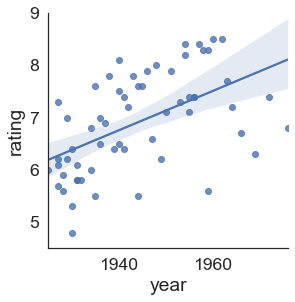

In [131]:
plot_df = films_and_features_to_analyze_df[['year', 'rating']]
sns.set(font_scale=1.6)
sns.set_style("white")
g=sns.lmplot(x='year', y='rating', data=plot_df, 
           fit_reg=True, aspect=1);
g.set(ylim=(4.5, 9))
g.set(xlim=(year_min, year_min+(year_max-year_min)))
g.fig.set_figwidth(4)
g.fig.set_figheight(4)

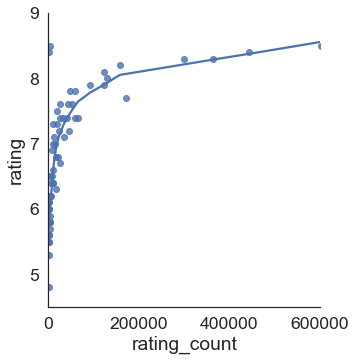

In [132]:
plot_df = films_and_features_to_analyze_df[['rating_count', 'rating']]
g=sns.lmplot(x='rating_count', y='rating', data=plot_df, 
           lowess=True,);
g.set(ylim=(4.5, 9))
g.set(xlim=(0, 600000))

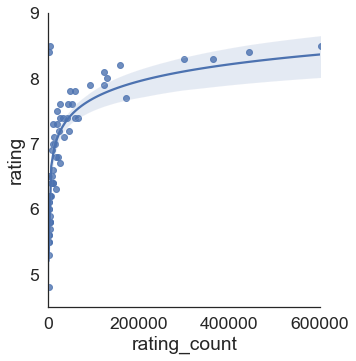

In [133]:
g=sns.lmplot(x='rating_count', y='rating', data=plot_df,
           logx=True,);
g.set(ylim=(4.5, 9))
g.set(xlim=(0, 600000))

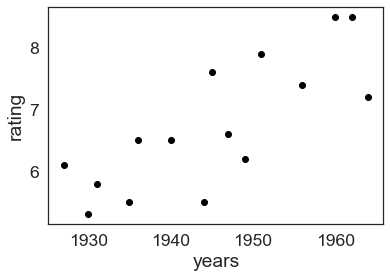

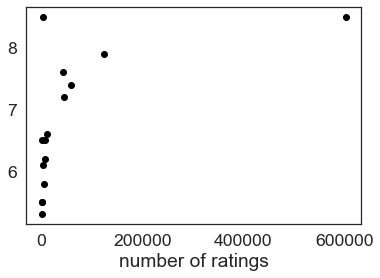

In [134]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to `log_rating_count` and maybe `year`


In [135]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.60
r2: 0.66


In [136]:
films_and_features_to_analyze_df.shape

(60, 26)

## Attempt LassoCV

In [137]:
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
X_cols = ['year', 'duration', 'rating_count']

#films_and_features_to_analyze_df_copy = copy.deepcopy(films_and_features_to_analyze_df) 

X= films_and_features_to_analyze_df[X_cols]
y= films_and_features_to_analyze_df['rating']

#selected_cols =cont_columns

X['log_year'] = np.log(X.year)
X['log_rating_count'] = np.log(X.rating_count)

# X_test_cont_w_log = copy.deepcopy(X_test_cont) 

# X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
# X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

# X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
# X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

# X= films_and_features_to_analyze_df[X_cols]
# y= films_and_features_to_analyze_df['rating']

<ipython-input-137-ad886dc0e91a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_year'] = np.log(X.year)
<ipython-input-137-ad886dc0e91a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_rating_count'] = np.log(X.rating_count)


In [138]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=12) #10
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=15)#30

#X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=.20, random_state=32)

ss=StandardScaler()

X_train_scaled = ss.fit_transform( X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.fit_transform( X_test )

In [139]:
X.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count'], dtype='object')

In [140]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

model = LassoCV()


In [141]:
poly=PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Degree 2 polynomial regression val R^2: 0.401


In [142]:
lm_poly.coef_

array([ 0.00000000e+00, -1.39197762e+02, -1.72612259e+03, -1.73349052e+00,
       -1.25414579e+00, -1.60412374e+01,  1.27863551e-03, -1.35748430e-01,
       -1.34443140e-04,  1.57143795e+01, -3.85515728e-02, -4.85267532e-07,
        3.21818165e-07,  2.62805782e+02, -9.34159126e-03,  5.16111967e-11,
        2.63454600e-01, -1.79150941e-05, -1.55246224e+01,  1.17325160e+01,
        1.90777326e-01])

In [143]:
lm_poly.fit(X_,y_)
print(f'Linear Regression test R^2: {lm_poly.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.682


In [144]:
#lm_poly.alpha_

In [145]:
#model.fit(X_train_scaled,y_train_val)

In [146]:
#model.coef_

In [147]:
#list(zip(X_cols, model.coef_))

In [148]:
#model.score(X_test, y_test)

In [149]:
#model.alpha_

## Repartition data set to analyze `budget` and  `worldwide_gross`

In [150]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [151]:
#films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]

In [152]:
first_actor_column = (len(films_to_analyze_financial_df.columns) - len(dict_of_all_actors))
first_actor_column


15

In [153]:
actor_columns = films_to_analyze_financial_df.iloc[:, first_actor_column:].columns
actor_columns


Index(['Leo G. Carroll', 'John Longden', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop', 'Cary Grant',
       'Edward Chapman', 'Basil Radford',
       ...
       'Brigitte Auber', 'Georgette Anys', 'Sara Berner', 'Wendell Corey',
       'Thelma Ritter', 'Raymond Burr', 'Judith Evelyn', 'Ross Bagdasarian',
       'Georgine Darcy', 'Ernest Thesiger'],
      dtype='object', length=633)

In [154]:
films_to_analyze_financial_df[actor_columns].sum()

Leo G. Carroll      6.0
John Longden        0.0
Edmund Gwenn        2.0
Gordon Harker       0.0
James Stewart       4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     0.0
Length: 633, dtype: float64

In [155]:
actors_num_of_appearances = films_to_analyze_financial_df[actor_columns].sum()
actors_num_of_appearances

Leo G. Carroll      6.0
John Longden        0.0
Edmund Gwenn        2.0
Gordon Harker       0.0
James Stewart       4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     0.0
Length: 633, dtype: float64

In [156]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Leo G. Carroll       True
John Longden        False
Edmund Gwenn        False
Gordon Harker       False
James Stewart        True
                    ...  
Raymond Burr        False
Judith Evelyn       False
Ross Bagdasarian    False
Georgine Darcy      False
Ernest Thesiger     False
Length: 633, dtype: bool

In [157]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 


Index(['Leo G. Carroll', 'James Stewart', 'Cary Grant', 'Grace Kelly',
       'Patricia Hitchcock'],
      dtype='object')

In [158]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'worldwide_gross','cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]
analysis_columns


['title',
 'year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Leo G. Carroll',
 'James Stewart',
 'Cary Grant',
 'Grace Kelly',
 'Patricia Hitchcock']

In [159]:
films_and_features_to_analyze_financial_df = films_to_analyze_financial_df[analysis_columns]

In [160]:
films_and_features_to_analyze_financial_df.head(10)

,title,year,duration,budget,worldwide_gross,cinematographer,documentary,tv_series,rating,rating_count,Leo G. Carroll,James Stewart,Cary Grant,Grace Kelly,Patricia Hitchcock
2,Family Plot,1976.0,120.0,4490375.0,13200000.0,Leonard J. South,0.0,0.0,6.8,20794.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,116.0,2000000.0,12600000.0,Gilbert Taylor,0.0,0.0,7.4,41424.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,143.0,4000000.0,6000000.0,Jack Hildyard,0.0,0.0,6.3,16714.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,128.0,6000000.0,13000000.0,John F. Warren,0.0,0.0,6.7,24727.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,130.0,3000000.0,7008058.0,Robert Burks,0.0,0.0,7.2,45220.0,0.0,0.0,0.0,0.0,0.0
7,The Birds,1963.0,119.0,2500000.0,11436184.0,Robert Burks,0.0,0.0,7.7,171549.0,0.0,0.0,0.0,0.0,0.0
10,Psycho,1960.0,109.0,806947.0,32000000.0,John L. Russell,0.0,0.0,8.5,603233.0,0.0,0.0,0.0,0.0,1.0
12,North by Northwest,1959.0,136.0,3101000.0,13369740.0,Robert Burks,0.0,0.0,8.3,298724.0,1.0,0.0,1.0,0.0,0.0
13,Vertigo,1958.0,128.0,2479000.0,3293831.0,Robert Burks,0.0,0.0,8.3,363752.0,0.0,1.0,0.0,0.0,0.0
15,Suspicion,1941.0,99.0,1103000.0,4500000.0,Harry Stradling Sr.,0.0,0.0,7.4,32739.0,1.0,0.0,1.0,0.0,0.0


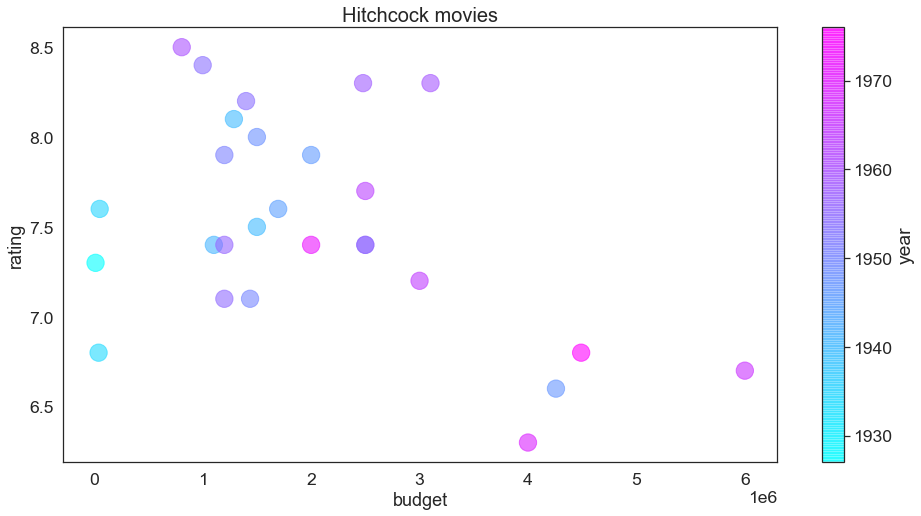

In [161]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

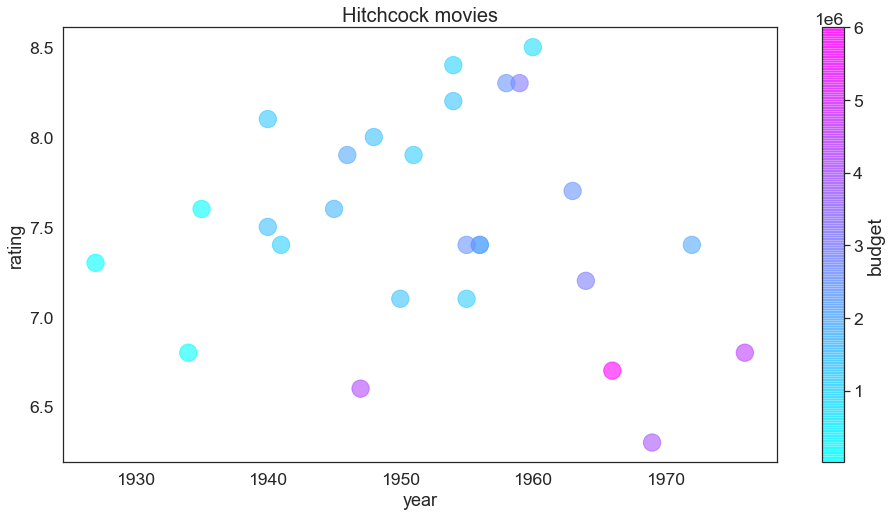

In [162]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'budget'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

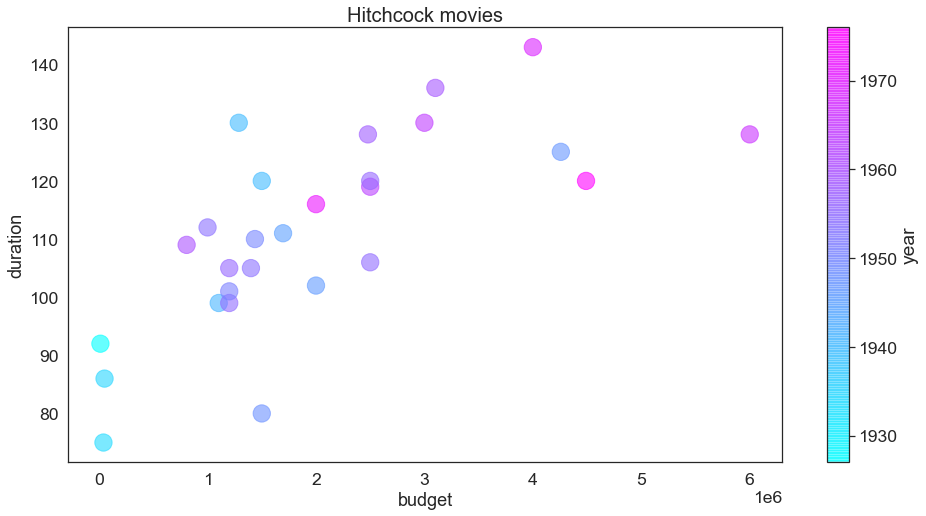

In [163]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [164]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

2

In [165]:
value_counts = films_and_features_to_analyze_financial_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_financial_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [166]:
selected_cols = [*films_and_features_to_analyze_financial_df.columns[1:8], *films_and_features_to_analyze_financial_df.columns[9:]]

In [167]:
selected_cols

['year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Leo G. Carroll',
 'James Stewart',
 'Cary Grant',
 'Grace Kelly',
 'Patricia Hitchcock']

In [168]:
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [170]:
### Preprocessing

#### Categorical Variable Preprocessing

cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [171]:


#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


columns=ohe.get_feature_names(cat_ohe_vars)

columns

X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

#### Repeating transformations on testing set

X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

X_train_cont = X_train[['year', 'duration', 'budget','rating_count']]
X_train_cont.head(70)



####  scale the continuous variables in the train set

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


#### select and scale the continuous variables in the test set

X_test_cont = X_test[['year', 'duration', 'budget','rating_count']]
X_test_cont.head()

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

### Combine the continuous, categorical, and ohe cat features for our testing set


cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

X_train.shape

### Combine the continuous and categorical features for our testing set


X_test_cat_df = X_test[cat_columns]

X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

### Now make predictions by instantiating the Linear Regression Model 

lr = LinearRegression()

lr.fit(X_train_combined, y_train)

lr.coef_

y_pred = lr.predict(X_test_combined)

y_pred

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

print(r2)

score = lr.score(X_test_combined, y_test) 
score

RMSE: 0.49
r2: 0.48
0.4833774354850594


0.4833774354850594

### Look at continous variable including `budget`

In [172]:
films_and_features_to_analyze_financial_df.columns

#selected_cols = ['budget', 'rating_count']
selected_cols = ['year', 'duration', 'budget']
#selected_cols = ['budget']
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [173]:


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [174]:
X_train.columns

Index(['year', 'duration', 'budget'], dtype='object')

In [175]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_train_scaled

array([[ 0.23362169, -0.30374139, -0.49187852],
       [ 0.55039686, -0.08081193, -0.75484111],
       [-2.0629983 , -1.02826213, -1.28668114],
       [ 0.39200927,  0.978103  ,  0.36380544],
       [-0.24154107, -0.02507956, -0.33331941],
       [-1.50864175, -1.97571233, -1.26794842],
       [ 0.0752341 , -0.30374139, -0.35807337],
       [-1.033479  ,  0.53224408, -0.29117079],
       [-1.42944796, -1.36265632, -1.26125816],
       [ 1.26314099,  1.81408848,  1.38139365],
       [-0.16234728, -0.52667085, -0.49187852],
       [-1.033479  ,  1.08956773, -0.43300425],
       [ 0.47120307,  1.42396192,  0.77993948],
       [-0.39992865, -1.69705051, -0.29117079],
       [ 1.02555962,  0.978103  ,  2.7194452 ],
       [ 0.1544279 , -0.63813558, -0.49187852],
       [ 0.1544279 , -0.24800902,  0.37785499],
       [ 1.81749754,  0.53224408,  1.70946716],
       [ 0.23362169,  0.53224408,  0.37785499],
       [ 1.50072237,  0.30931462,  0.0433421 ]])

In [176]:
cont_columns = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,year,duration,budget
40,0.233622,-0.303741,-0.491879
25,0.550397,-0.080812,-0.754841
19,-2.062998,-1.028262,-1.286681
24,0.392009,0.978103,0.363805
30,-0.241541,-0.025080,-0.333319


In [177]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,budget
0,0.233622,-0.303741,-0.491879
1,0.550397,-0.080812,-0.754841
2,-2.062998,-1.028262,-1.286681
3,0.392009,0.978103,0.363805
4,-0.241541,-0.025080,-0.333319


In [178]:
#X_test = X_test[['year', 'budget','rating_count']]

X_test = X_test[selected_cols]
X_test.head()

X_test_scaled = ss.transform(X_test)

cont_columns = X_test.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test.index)

X_test_scaled_df.head()

,year,duration,budget
28,-0.479122,0.810906,1.554002
15,-0.954285,-0.638136,-0.556774
6,0.867172,1.089568,0.712368
29,-0.558316,-0.470938,0.043342
21,0.075234,0.086385,-0.625684


In [179]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,budget
0,-0.479122,0.810906,1.554002
1,-0.954285,-0.638136,-0.556774
2,0.867172,1.089568,0.712368
3,-0.558316,-0.470938,0.043342
4,0.075234,0.086385,-0.625684
5,0.787978,0.476512,0.377855
6,-0.637510,0.030653,-0.159790


In [180]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

lr.coef_

array([ 0.11479943,  0.24625262, -0.4791347 ])

In [181]:
y_pred = lr.predict(X_test_combined)

y_pred

array([6.9051083 , 7.50507579, 7.5315396 , 7.30416907, 7.83469617,
       7.53175828, 7.51592324])

In [182]:

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.36
r2: 0.52


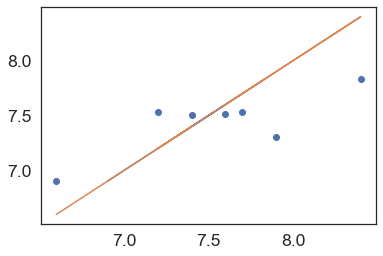

In [183]:
plt.scatter(y_test, y_pred)
plt.plot(y_pred, y_pred)
plt.plot(y_test, y_test)

In [184]:
res = y_test-y_pred
res

28   -0.305108
15   -0.105076
6    -0.331540
29    0.595831
21    0.565304
7     0.168242
30    0.084077
Name: rating, dtype: float64

In [185]:
X_test

,year,duration,budget
28,1947.0,125.0,4258000.0
15,1941.0,99.0,1103000.0
6,1964.0,130.0,3000000.0
29,1946.0,102.0,2000000.0
21,1954.0,112.0,1000000.0
7,1963.0,119.0,2500000.0
30,1945.0,111.0,1696377.0


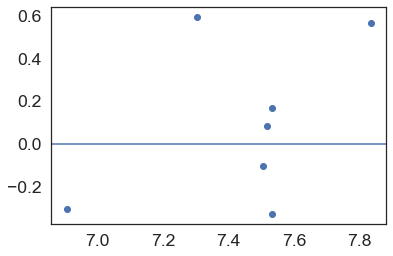

In [186]:
plt.scatter(y_pred, res)
plt.axhline(y=0)
#plt.plot(y_pred, 0)

In [187]:
X_train_combined.head()

,year,duration,budget
0,0.233622,-0.303741,-0.491879
1,0.550397,-0.080812,-0.754841
2,-2.062998,-1.028262,-1.286681
3,0.392009,0.978103,0.363805
4,-0.241541,-0.025080,-0.333319


In [188]:
X_train_cont

,year,duration,budget,rating_count
40,1940.0,130.0,1288000.0,123730.0
25,1950.0,110.0,1437000.0,12770.0
19,1955.0,99.0,1200000.0,33737.0
24,1951.0,101.0,1200000.0,123219.0
30,1945.0,111.0,1696377.0,43415.0
16,1956.0,105.0,1200000.0,25655.0
10,1960.0,109.0,806947.0,603233.0
7,1963.0,119.0,2500000.0,171549.0
3,1972.0,116.0,2000000.0,41424.0
29,1946.0,102.0,2000000.0,92192.0


In [189]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([-3.35812004, -0.63802255,  0.03509693, -0.47786606, -0.14797963])

In [190]:
lm.score

<bound method RegressorMixin.score of LinearRegression()>

## include `log(year)` `budget^2` and `log(rating_count)`

In [191]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

#X_train_cont_w_log['log_budget'] = np.log(X_train_cont_w_log.budget)
#X_test_cont_w_log['log_budget'] = np.log(X_test_cont_w_log.budget)
X_train_cont_w_log['pow_budget'] = X_train_cont_w_log.budget**2
X_test_cont_w_log['pow_budget'] =  X_test_cont_w_log.budget**2


X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)


In [192]:
# films_and_features_to_analyze_financial_df.columns

#selected_cols = [ 'log_year', 'log_budget', 'log_rating_count']
selected_cols = ['year','budget', 'rating_count', 'log_year', 'pow_budget', 'log_rating_count']
# #selected_cols = ['year', 'duration', 'budget', 'rating_count']
# #selected_cols = ['budget']
# X= films_and_features_to_analyze_financial_df[selected_cols]
# y= films_and_features_to_analyze_financial_df['rating']

X_train_cont_w_log = X_train_cont_w_log[ selected_cols ]
X_test_cont_w_log  = X_test_cont_w_log[ selected_cols ]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train.columns

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)
X_train_scaled.shape

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)
X_train_scaled_df.head()

X_test_scaled_df = ss.transform(X_test_cont_w_log)

In [193]:
X_test_scaled_df

array([[-1.64378336, -1.50584007, -0.39813808, -1.64709471, -0.66259956,
        -0.11150877],
       [ 0.13075549, -0.73924897,  2.40205385,  0.13334038, -0.53561108,
         1.87538925],
       [ 1.06472331,  0.87462702, -0.44493999,  1.06347014,  0.48284288,
        -0.23656505],
       [ 2.18548469,  2.07726724, -0.61960518,  2.17339454,  1.9040276 ,
        -0.9552871 ],
       [-0.52302198,  1.88975502, -0.69596846, -0.5205871 ,  1.64522526,
        -1.62198827],
       [-1.73718014, -1.51390945, -0.64683538, -1.74128547, -0.66271413,
        -1.14242082],
       [ 0.5977394 ,  0.95612776,  1.36781372,  0.59899876,  0.56128942,
         1.51009088]])

In [194]:
cont_columns = X_test_cont_w_log.columns
cont_columns

Index(['year', 'budget', 'rating_count', 'log_year', 'pow_budget',
       'log_rating_count'],
      dtype='object')

In [195]:
X_test_scaled_df

array([[-1.64378336, -1.50584007, -0.39813808, -1.64709471, -0.66259956,
        -0.11150877],
       [ 0.13075549, -0.73924897,  2.40205385,  0.13334038, -0.53561108,
         1.87538925],
       [ 1.06472331,  0.87462702, -0.44493999,  1.06347014,  0.48284288,
        -0.23656505],
       [ 2.18548469,  2.07726724, -0.61960518,  2.17339454,  1.9040276 ,
        -0.9552871 ],
       [-0.52302198,  1.88975502, -0.69596846, -0.5205871 ,  1.64522526,
        -1.62198827],
       [-1.73718014, -1.51390945, -0.64683538, -1.74128547, -0.66271413,
        -1.14242082],
       [ 0.5977394 ,  0.95612776,  1.36781372,  0.59899876,  0.56128942,
         1.51009088]])

In [196]:
cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled)


In [197]:
# X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

# X_train_combined.head()


# X_test_cont = X_test[['year','budget', 'rating_count', 'log_year', 'log_budget', 'log_rating_count']]
# X_test_cont.head()




X_test_scaled_df.head()

# X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

# X_test_combined

lr = LinearRegression()

lr.fit(X_train_scaled_df,y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred



from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

X_train_scaled_df.head()

RMSE: 0.74
r2: -1.02


,year,budget,rating_count,log_year,pow_budget,log_rating_count
40,-1.176799,-0.506851,0.116468,-1.176870,-0.451723,0.694651
25,-0.242832,-0.386617,-0.676983,-0.240045,-0.400033,-1.406356
19,0.224152,-0.577861,-0.527053,0.226567,-0.479596,-0.507581
24,-0.149435,-0.577861,0.112814,-0.146627,-0.479596,0.690822
30,-0.709816,-0.177316,-0.457847,-0.707855,-0.296568,-0.274250
